In [474]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from faker import Faker
import random

import datetime
import dateutil

from IPython.core.display import display

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import  SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# 1 - Analisis exploratorio de datos

Efectúe un profundo EDA del dataset entregado. En caso de que existan dudas de la
semántica de alguno de los features del dataset, se recomienda fuertemente investigar
sobre el mismo y documentar el resultado.

time: Cantidad de dias en que se realizo el seguimiento.

In [475]:
cols_not_boolean = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
    'time'
]


def display_corr(_df):
    corr = _df.corr()
    mask = np.ones_like(corr, dtype=bool)
    for _i in range(len(mask[0])):
        for _j in range(len(mask[1])):
            if _j <= _i:
                mask[_i][_j] = not mask[_i][_j]
    plt.subplots(figsize=(10, 10))
    cmap = sns.color_palette("Spectral", as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, square=True, linewidths=.5,
                cbar_kws={"shrink": .7})


def normalize(_df):
    cols = [_x for _x in _df]
    _x = _df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(_x)
    _df = pd.DataFrame(x_scaled, columns=cols)
    return _df


def display_info(_df):
    _df.info()
    _df.describe()
    # print(_df.isna().sum())
    _df.hist(bins=30, figsize=(20, 14))


def remove_outlier(_df):
    for column in _df:
        q1 = _df[column].quantile(0.25)
        q3 = _df[column].quantile(0.75)
        iqr = q3 - q1  #IQR is interquartile range.
        _filter = (_df[column] >= q1 - 1.5 * iqr) & (_df[column] <= q3 + 1.5 * iqr)
        _df = _df.loc[_filter]
    return _df


def display_boxplots(_df, cols, _ref):
    n_cols = 4
    n_rows = (len(cols) // 4) + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    for _i, column in enumerate(cols):
        _x = _i % n_cols
        _y = _i // n_cols
        sns.boxplot(y=column, x=_ref, data=_df, ax=ax[_y, _x])
        ax[_y, _x].set_title(column)


def display_outlier(_df, cols):
    n_cols = 4
    n_rows = (len(cols) // 4) + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    for _i, column in enumerate(cols):
        _x = _i % n_cols
        _y = _i // n_cols
        sns.boxplot(y=column, data=_df, ax=ax[_y, _x])
        sns.stripplot(y=column, data=_df, jitter=True, edgecolor="gray", ax=ax[_y, _x])
        ax[_y, _x].set_title(column)

In [476]:
df = pd.read_csv('.\heart_failure_clinical_records_dataset.csv')

### Outliers

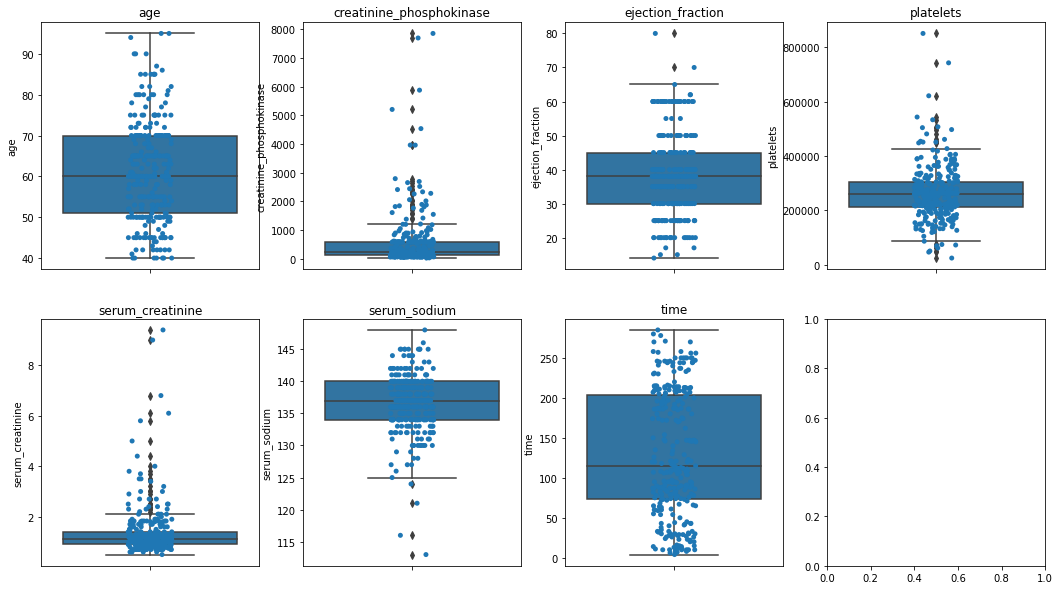

In [477]:
display_outlier(df, cols_not_boolean)
df_n = normalize(df)
df_o = remove_outlier(df)
df_o_n = remove_outlier(df_n)

### Información

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       224 non-null    float64
 1   anaemia                   224 non-null    float64
 2   creatinine_phosphokinase  224 non-null    float64
 3   diabetes                  224 non-null    float64
 4   ejection_fraction         224 non-null    float64
 5   high_blood_pressure       224 non-null    float64
 6   platelets                 224 non-null    float64
 7   serum_creatinine          224 non-null    float64
 8   serum_sodium              224 non-null    float64
 9   sex                       224 non-null    float64
 10  smoking                   224 non-null    float64
 11  time                      224 non-null    float64
 12  DEATH_EVENT               224 non-null    float64
dtypes: float64(13)
memory usage: 24.5 KB


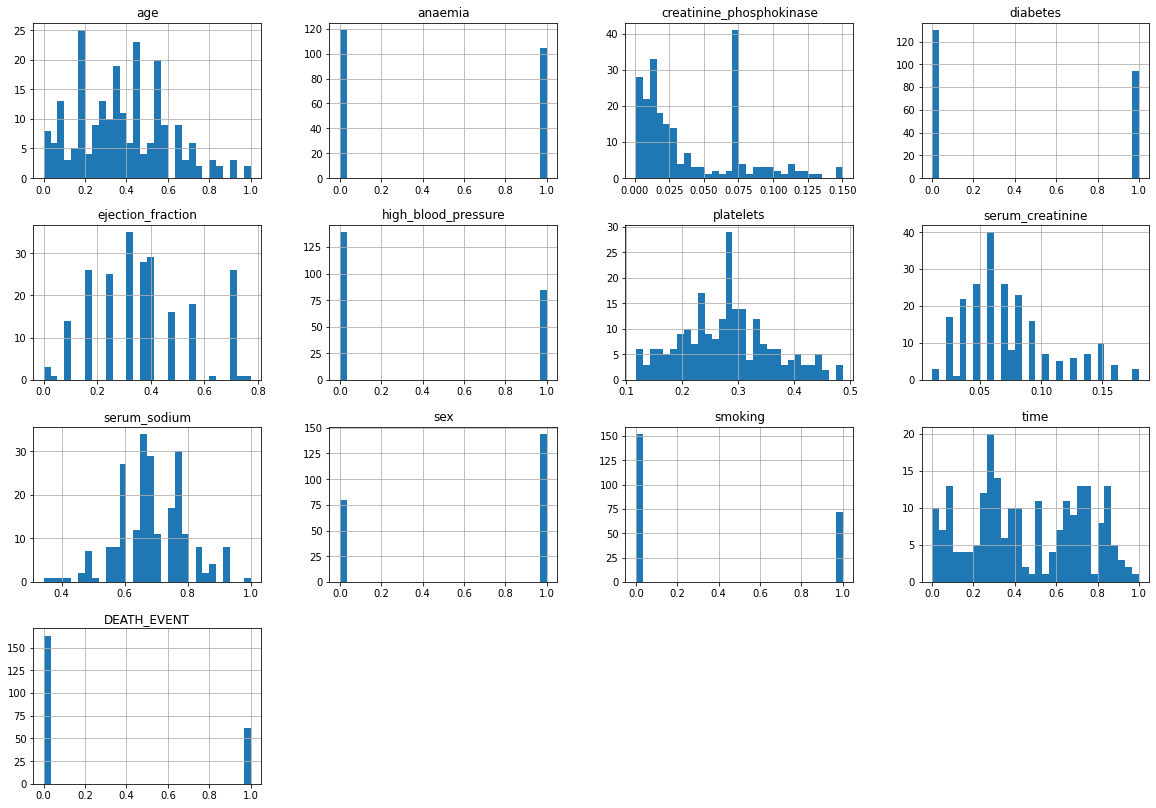

In [478]:
display_info(df_o_n)

### Correlación

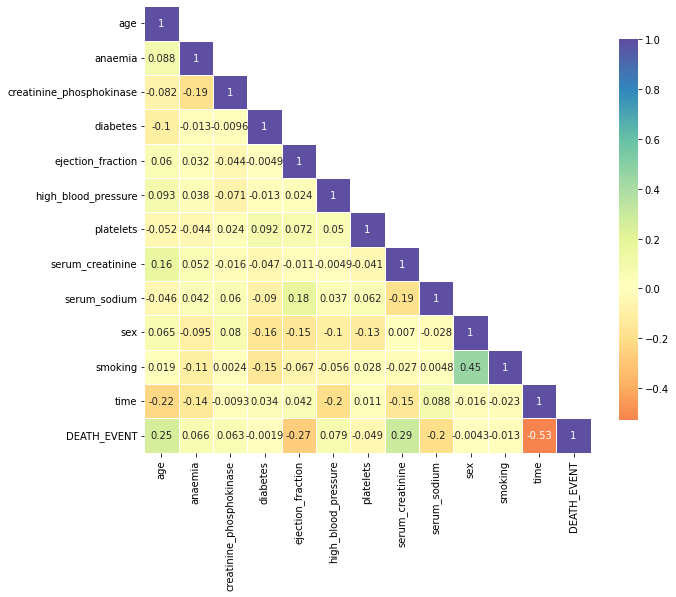

In [491]:
display_corr(df)

### Correlación normalizada y sin ouliers

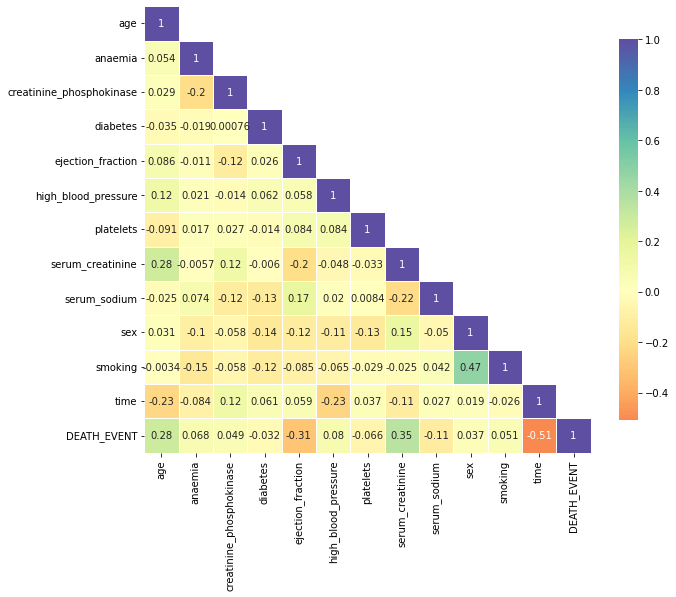

In [492]:
display_corr(df_o_n)

### Distribución de los datos

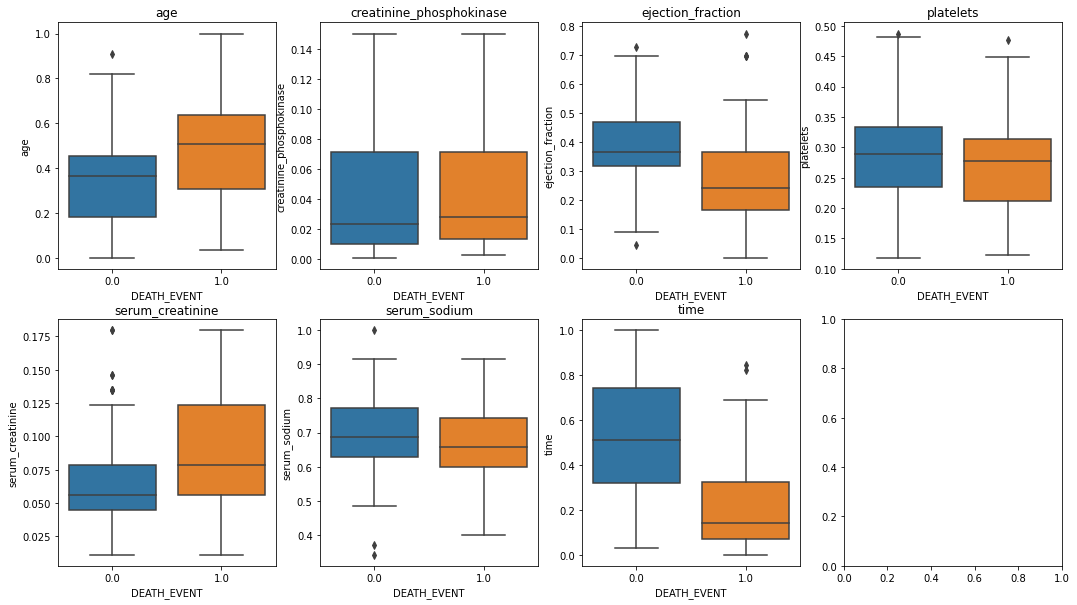

In [480]:
referencia = 'DEATH_EVENT'
display_boxplots(df_o_n, cols_not_boolean, referencia)

Decidimos eliminar los outliers.

Podemos ver una correlacion entre la edad y creatinina serum, la edad y el evento de muerte, el evento de muerte con la creatinina en sangre y el sexo con fumar. Estos valores no nos sorprendieron ya que tienen sentido, y eran esperables.

Por otro lado, hay una correlacion inversa entre el volumen ejectado en cada pulsacion (ejection fraction) con el evento de muerte, asi como el tiempo de seguimiento del paciente con el evento de muerte. Esta ultima relacion nos sorprendio, ya que no esperabamos que tuvieran una relacion de ningun tipo entre si, pero estimamos que deberia ser porque al estar el paciente con un mayor numero de estudios, es mas facil prevenir posibles problemas.

# 2 - Caracteristicas de la población con mayor riesgo de muerte por accidentes cardiovasculares

Utilizando las técnicas vistas en el curso, detecte las características de las poblaciones
con mayor riesgo de muerte producto de un accidente cardiovascular.

Podemos ver una mayor valor de correlacion con "DEATH_EVENT" para los siguientes features: age, ejection_fraction, serum_creatinine y "time".

In [481]:



x = df_o.drop(['DEATH_EVENT'], axis=1)
y = df_o['DEATH_EVENT']


sample = int(0.85 * len(y))
x_train, x_test, y_train, y_test = x[:sample], x[sample:], y[:sample], y[sample:]


high_score = 0
score_list = []

for n in range(1,13):
    _model = LogisticRegression(max_iter=1000)

    print(n)
    rfe = RFE(_model, n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(x_train, y_train)
    X_test_rfe = rfe.transform(x_test)
    _model.fit(X_train_rfe, y_train)
    score = _model.score(X_test_rfe, y_test)
    score_list.append(score)
    if score >= high_score:
        high_score = score
        names=rfe.get_feature_names_out()
        print(names)
        nof = n
print(f"Optimum number of features:{nof}")

1
['serum_creatinine']
2
['high_blood_pressure' 'serum_creatinine']
3
['high_blood_pressure' 'serum_creatinine' 'smoking']
4
5
6
['anaemia' 'ejection_fraction' 'high_blood_pressure' 'serum_creatinine'
 'sex' 'smoking']
7
['age' 'anaemia' 'ejection_fraction' 'high_blood_pressure'
 'serum_creatinine' 'sex' 'smoking']
8
['age' 'anaemia' 'diabetes' 'ejection_fraction' 'high_blood_pressure'
 'serum_creatinine' 'sex' 'smoking']
9
10
11
12
Optimum number of features:8


Cantidad de features optimos 8:
'age' 'anaemia' 'diabetes' 'ejection_fraction' 'high_blood_pressure'
 'serum_creatinine' 'sex' 'smoking'


Dentro de ellos los 3 mas importantes son:
'high_blood_pressure' 'serum_creatinine' 'smoking


In [482]:

def best_k_cluster_silueta(_df, _a, _b, _title, _y, _x, _axs):
    sil = []
    for k in range(_a, _b):
        km = KMeans(n_clusters=k).fit(_df)
        sil.append(silhouette_score(_df, km.labels_, metric='euclidean'))
    _axs[_y, _x].plot(range(_a, _b), sil, 'bx-')
    _axs[_y, _x].set_title(_title + str(_b))
    return _axs

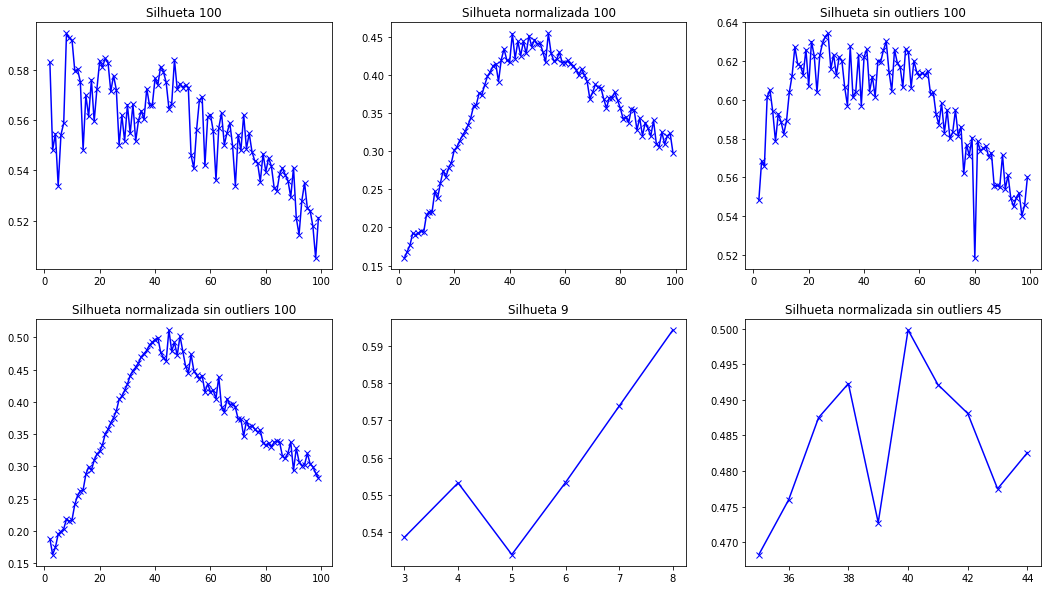

In [483]:
pca = PCA(n_components=12)
pca.fit(df_o_n)
pca_samples = pca.transform(df_o_n)
psn = pd.DataFrame(pca_samples)

fig, ax = plt.subplots(2, 3, figsize=(18, 5 * 2))
ax = best_k_cluster_silueta(df, 2, 100, 'Silhueta ', 0, 0, ax) #k=8
ax = best_k_cluster_silueta(df_n, 2, 100, 'Silhueta normalizada ', 0, 1, ax) #k=43
ax = best_k_cluster_silueta(df_o, 2, 100, 'Silhueta sin outliers ', 0, 2, ax)#k=34
ax = best_k_cluster_silueta(df_o_n, 2, 100, 'Silhueta normalizada sin outliers ', 1, 0, ax)#k=43
ax = best_k_cluster_silueta(df, 3, 9, 'Silhueta ', 1, 1, ax)
ax = best_k_cluster_silueta(df_o_n, 35, 45, 'Silhueta normalizada sin outliers ', 1, 2, ax)

Se encontro el numero optimo de clusters relevantes = 8 para el dataset no normalizado y sin remover outliers.
Y un numeor alrededor de 43 para el normalizado sin outliers




# 3 - Conjunto de resultados clinicos

Para las poblaciones de mayor riesgo, en función de las respuestas obtenidas en el formulario de alta, determine el conjunto de resultados clínicos que el potencial asegurado debe entregar para avanzar en el proceso de obtención de la póliza.


Utilizando los resultados anteriores, podemos decir que los datos más relevantes para determinar las caracteristicas de la población con mayor riesgo de muerte a causa de accidentes cardiovasculares son high_blood_pressure, serum_creatinine y smoking.

# 4 - Modelo predictivo

Para el conjunto de respuestas obtenidas en el formulario de alta, diseñe un modelo
predictivo que determine si el potencial asegurado requiere de la realización de análisis
clínicos adicionales o la póliza le será entregada sin averiguaciones adicionales.
Documente detalladamente todas las decisiones tomadas.
Actualmente no existen formularios digitalizados con las respuestas de los asegurados, por
lo que es necesario la generación de datos sintéticos que representen las distintas
poblaciones. Esto datos serán los utilizados para el entrenamiento y test del modelo
predictivo.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       10000 non-null  object 
 1   ages       10000 non-null  int64  
 2   weight     10000 non-null  int64  
 3   height     10000 non-null  int64  
 4   imc        10000 non-null  float64
 5   sports     10000 non-null  int64  
 6   smoking    10000 non-null  int64  
 7   risk       10000 non-null  int64  
 8   tension    10000 non-null  int64  
 9   cardio     10000 non-null  int64  
 10  treatment  10000 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 859.5+ KB


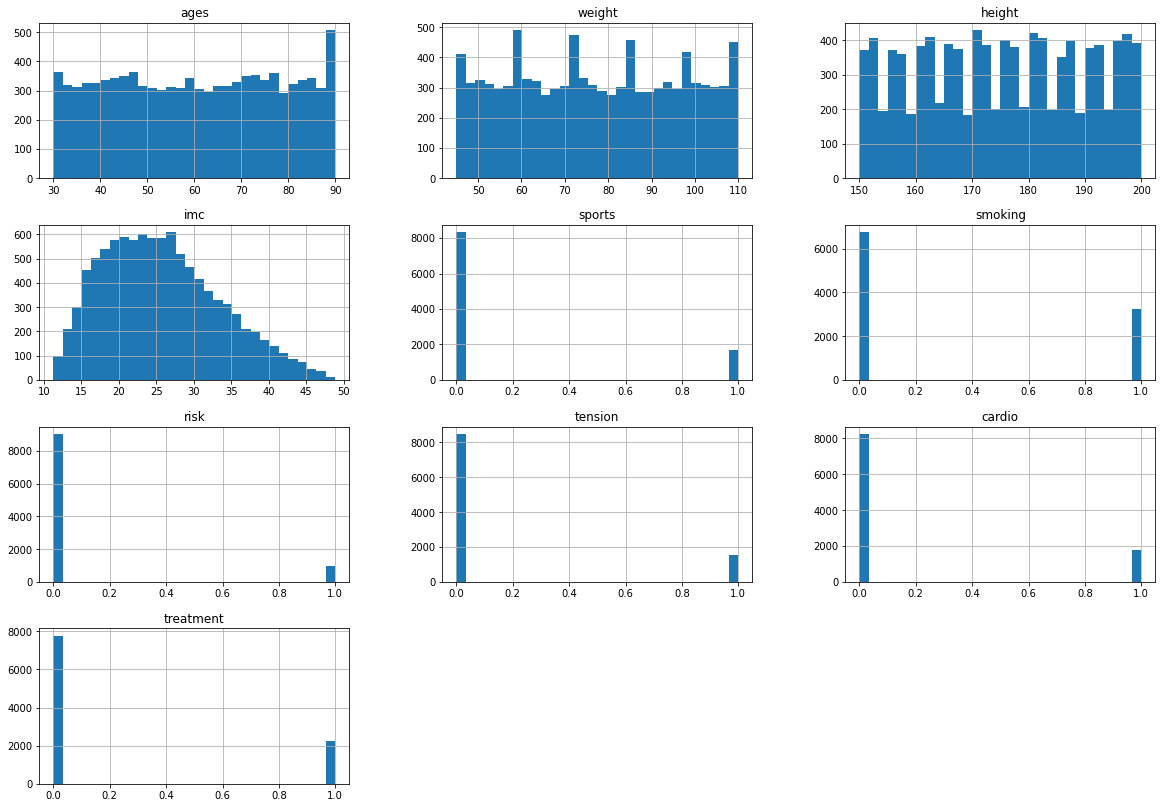

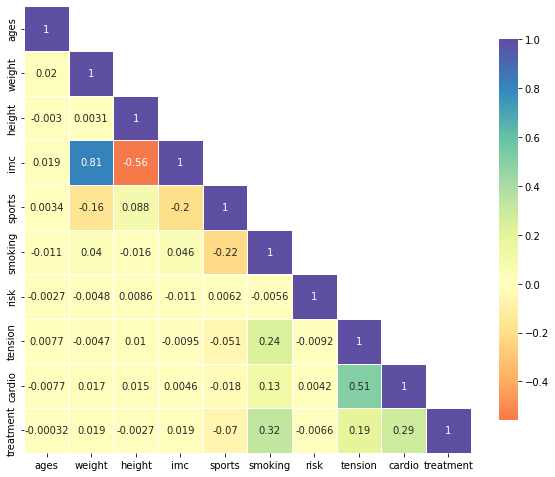

In [484]:
def get_names(samples):
    _names = []
    fake = Faker()
    for _i in range(samples):
        _names.append(fake.name())
    return _names

def get_birth(samples):
    _birth = []
    for _i in range(samples):
        _birth.append(random.randint(30, 90))
    return _birth

def get_weight(samples):
    _weight = []
    for _i in range(samples):
        _weight.append(random.randint(45, 110))
    return _weight

def get_height(samples):
    _height = []
    for _i in range(samples):
        _height.append(random.randint(150, 200))
    return _height

def get_imc(samples, height, weight):
    _imc = []
    for _i in range(samples):
        _imc.append(weight[_i] / (height[_i] / 100) ** 2)
    return _imc

def get_sport(samples, _imc):
    _sports = []
    for _i in range(samples):
        _p = random.randint(0, 100)
        if _imc[_i] < 18.5:
            if _p < 15:
                _sports.append(1)
            else:
                _sports.append(0)
        elif 18.5 <= _imc[_i] <= 24.9:
            if _p < 33:
                _sports.append(1)
            else:
                _sports.append(0)
        elif 25 <= _imc[_i] <= 29.9:
            if _p < 18:
                _sports.append(1)
            else:
                _sports.append(0)
        else:
            if _p < 2:
                _sports.append(1)
            else:
                _sports.append(0)
    return _sports

def get_smoking(samples, sports):
    _smoke = []
    for _i in range(samples):
        temp = random.randint(0, 10)
        if sports[_i] == 1:
            if temp == 0:
                _smoke.append(1)
            else:
                _smoke.append(0)
        else:
            if temp <= 3:
                _smoke.append(1)
            else:
                _smoke.append(0)
    return _smoke

def get_tension(samples, smoking):
    _tension = []
    for _i in range(samples):
        temp = random.randint(0, 10)
        if smoking[_i] == 0:
            if temp == 0:
                _tension.append(1)
            else:
                _tension.append(0)
        else:
            if temp <= 2:
                _tension.append(1)
            else:
                _tension.append(0)
    return _tension

def get_cardiovascular(samples, tension):
    _cardio = []
    for _i in range(samples):
        temp = random.randint(0, 10)
        if tension[_i] == 1:
            if temp <= 6:
                _cardio.append(1)
            else:
                _cardio.append(0)
        else:
            if temp == 0:
                _cardio.append(1)
            else:
                _cardio.append(0)
    return _cardio

def get_risk(samples):
    _risk = []
    for _i in range(samples):
        temp = random.randint(0, 10)
        if temp == 0:
            _risk.append(1)
        else:
            _risk.append(0)
    return _risk

def get_treatment(samples, cardiovascular, smoking):
    _treatment = []
    for _i in range(samples):
        temp = random.randint(0, 10)
        if cardiovascular[_i] == 1:
            if smoking[_i] == 1:
                if temp <= 6:
                    _treatment.append(1)
                else:
                    _treatment.append(0)
            else:
                if temp <= 3:
                    _treatment.append(1)
                else:
                    _treatment.append(0)
        else:
            if smoking[_i] == 1:
                if temp <= 3:
                    _treatment.append(1)
                else:
                    _treatment.append(0)
            else:
                if temp == 0:
                    _treatment.append(1)
                else:
                    _treatment.append(0)
    return _treatment

def random_data_generation(samples):
    names = get_names(samples)
    ages = get_birth(samples)
    weight = get_weight(samples)
    height = get_height(samples)
    imc = get_imc(samples, height, weight)
    sports = get_sport(samples, imc)
    smoking = get_smoking(samples, sports)
    risk = get_risk(samples)
    tension = get_tension(samples, smoking)
    cardio = get_cardiovascular(samples, tension)
    treatment = get_treatment(samples, cardio, smoking)

    _df = pd.DataFrame()
    _df['name'] = names
    _df['ages'] = ages
    _df['weight'] = weight
    _df['height'] = height
    _df['imc'] = imc
    _df['sports'] = sports
    _df['smoking'] = smoking
    _df['risk'] = risk
    _df['tension'] = tension
    _df['cardio'] = cardio
    _df['treatment'] = treatment

    return _df

df_fake = random_data_generation(10000)
display_info(df_fake)
display_corr(df_fake)

In [485]:
#NO CORRER ESTO
#best_k_cluster_silueta(df_fake.drop(['name'], axis=1),2,10)

In [486]:
def crear_modelo(_df,k):
    _algorithm = (KMeans(n_clusters=k, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001, random_state= 111, algorithm='elkan') )
    temp=_df.drop(['name'], axis=1)
    _algorithm.fit(temp)
    _x=temp
    _y=_algorithm.labels_

    _modelo = SVC()
    _sample = int(.85 * len(y))
    _x_train, _x_test, _y_train, _y_test = _x[:_sample], _x[_sample:], _y[:_sample], _y[_sample:]
    _rfe = RFE(_modelo, n_features_to_select=n)

    _X_train_rfe = rfe.fit_transform(_x_train, _y_train)
    _X_test_rfe = rfe.transform(_x_test)


    _modelo.fit(_X_train_rfe, _y_train)
    _score = _modelo.score(_X_test_rfe, _y_test)
    print(f'El modelo tiene un score de: {_score}')#esta gucci

    return _modelo , _algorithm.labels_

model, labels= crear_modelo(df_fake, 6)
df_temp=df_fake.copy()
df_temp['labels']= labels
dfs= create_sub_df(df_temp,6)



a =[]
for _df in dfs:
    cols=_df.drop(['name'],axis=1).columns
    a.append(_df.mean().to_numpy())
a=np.array(a)
df_means=pd.DataFrame(a, columns=cols)


El modelo tiene un score de: 0.9115188583078492


C:\Users\59898\-UM\AI\Final\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\59898\AppData\Local\Temp/ipykernel_30952/2126345724.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  a.append(_df.mean().to_numpy())


Estudio de clusters

In [487]:
def create_sub_df(_df,n):
    _dfs=[]
    for i in range(n):
        _df_t = _df.loc[_df['labels'] == i]
        _dfs.append(_df_t)
    return  _dfs

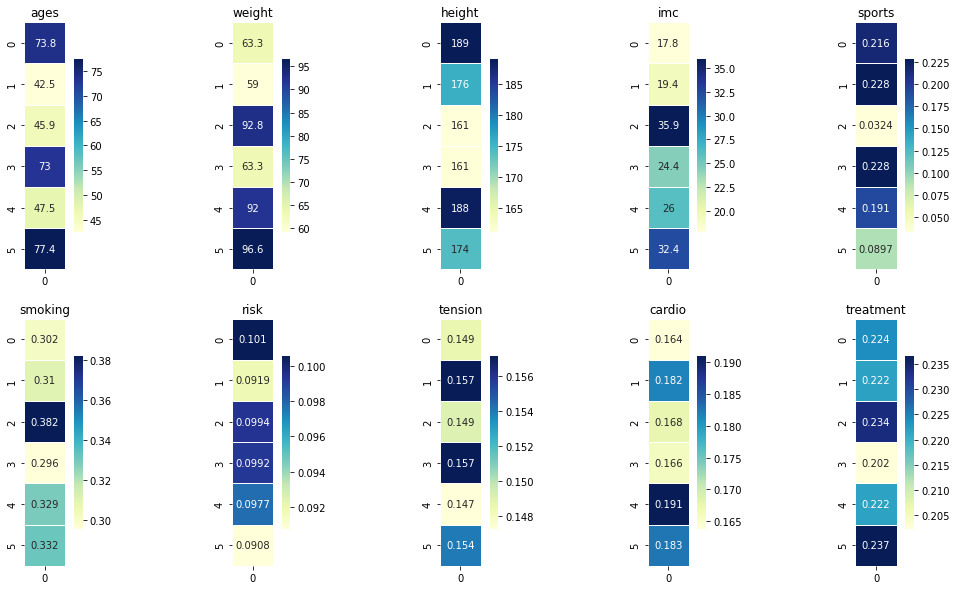

In [488]:

def display_differences(_dfs):
    _dfs=_dfs.drop('labels',axis=1)
    n_cols = 5
    cols=_dfs.columns
    n_rows = (len(cols) // n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    for _i, column in enumerate(cols):
        _x = _i % n_cols
        _y = _i // n_cols
        sns.heatmap(_dfs[column].to_numpy().reshape(_dfs[column].to_numpy().shape[0],1), vmax=_dfs[column].max(),
                    vmin=_dfs[column].min(), annot=True, fmt='.3g', square=True, linewidths=.5, cbar_kws={"shrink": .7},
                    ax=ax[_y, _x], cmap='YlGnBu')
        ax[_y, _x].set_title(column)
df_means.head()
display_differences(df_means)


#display_means(df_means.to_numpy(),cols)

In [489]:
print(df_means.head())
def display_means(metric, names):
    for colum in metric:
        y = colum
        x = np.arange(0,len(y),1)
        plt.plot( x, y, alpha=0.8)
        plt.legend()
    plt.xticks(x,names,rotation=45)
    plt.show()

casoA = [2,4]
casoB = [1]
casoC = [5]
casoD = [0,3]

def deberia_dar_seguro(X,resultado):
    if resultado in casoD:
        return False
    if resultado in casoC:
        return X[5]+X[7]+X[8]+X[9]-X[4]*.5 >= 1.5
    if resultado in casoB:
        return X[5]+X[7]+X[8]+X[9]-X[4]*.5 > 2.5
    if resultado in casoA:
        return  True

        ages     weight      height        imc    sports   smoking      risk  \
0  73.838710  63.292853  188.901328  17.777228  0.216319  0.301708  0.100569   
1  42.485442  58.983936  175.709337  19.394605  0.228414  0.310241  0.091867   
2  45.857833  92.821946  161.153899  35.889286  0.032436  0.382333  0.099379   
3  73.026718  63.272265  161.465013  24.418942  0.227735  0.295802  0.099237   
4  47.533762  91.967846  188.478457  25.997311  0.190997  0.329260  0.097749   

    tension    cardio  treatment  labels  
0  0.148640  0.163820   0.223909     0.0  
1  0.157129  0.181727   0.221888     1.0  
2  0.149068  0.167702   0.233954     2.0  
3  0.157125  0.166031   0.202290     3.0  
4  0.147267  0.190997   0.221865     4.0  


El orden de los clusters varia en cada iteracion, pero se mantienen las propiedades de los clusters, por lo que podemos decir que tenemos A, B, C, D, E y F.

Podemos identificar el caso E y F porque se caracteriza por tener un IMC con un indice muy alto (mayor a 30, es decir, obeso) y hacen pocas actividades deportivas. Estos tienen un alto porcentaje de usuarios con tratamientos previos. Estos son los grupos que no deberian aplicar para la poliza del seguro.

El caso A y B, es el ideal, presentando buenos valores de IMC, asi como tambien suelen ser jovenes, y hacen deporte. Estos tambien tienden a fumar menos, y tener menos tendencias a enfermedades cronicas, y haber tenido tratamientos. Son los grupos más faciles de categorizar como que se les acepta la poliza del seguro.

Despues tenemos el caso C, donde son jovenes con un IMC medio, y valores promedio de lo demas. Si bien estos no entran en la categoria para entregarles el seguro sin dudarlo, cumplen una cierta cantidad de atributos para poder recibir el seguro sin analisis extras.

Por ultimo, el caso D, son viejos, con un IMC medio, y valores promedio de lo demas. Estos consideramos que deberian realizarse analisis extra (que mostramos en el codigo  con la funcion deberia_dar_seguro()).


